# [E-04] Make a Lyrict


## 1. 데이터 불러오기

In [37]:
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


## 2. 데이터 전처리 
- 정체방법은 코드에 적어둠
- 단어수가 3개 이하인 문장과 15개 이상인 문장은 학습할때 방해될거같아 sentence에 넣지 않았다.
- 단어수 3개 이하인것과 15개 이상은 padding할때 안좋을 거같아 넘어갔다.

In [39]:
import re
def preprocess_sentence(sentence): #처리과정
    sentence = sentence.lower().strip() # 소문자 처리
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 특수문자제거
    sentence = re.sub(r'[" "]+', " ", sentence) # 연속된 공백제거
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) #a-z A-Z.!아닌 문자 제거
    sentence = sentence.strip() # 5 # 양쪽의 공백 제거
    sentence = '<start> ' + sentence + ' <end>' #inputdat를 만들기 위해 해줌
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [49]:
corpus = [] #input를 저장하기 위한 리스트

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    #if len(sentence.split())>15: continue
    if len(sentence) <= 1: continue   #단어수가 1개이거나 한줄자체가 비어있는 경우 넘어가자
    if len(sentence.split())<3: continue #단어수 3개이하 애는 건너뜀
    if len(sentence.split())>15 : continue #단어수 15개 이상인 애는 건너뜀
    # 정제를 하고 담아주세요
    pp_sentence = preprocess_sentence(sentence)
    corpus.append(pp_sentence)
        
corpus

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>',
 '<start> you saw her bathing on the roof <end>',
 '<start> her beauty and the moonlight overthrew her <end>',
 '<start> she tied you <end>',
 '<start> to a kitchen chair <end>',
 '<start> she broke your throne , and she cut your hair <end>',
 '<start> and from your lips she drew the hallelujah hallelujah <end>',
 '<start> hallelujah you say i took the name in vain <end>',
 '<start> i don t even know the name <end>',
 '<start> but if i did , well really , what s it to you ? <end>',
 '<start> there s a blaze of light <end>',
 '<start> in every 

In [51]:
import os, re 
import numpy as np
import tensorflow as tf
# 토큰화 : 문장을 일정한 기준으로 쪼개는 과정
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words= 14000, #단어장의 개수  
        filters=' ',#쓰지않겠다. 애초에 전처리를 위해서 필요한 친구 아마 정규식으로도 가능할듯?
        oov_token="<unk>" #14000단어에 포함되지않는 단어가 나오게 되면 <unk>라고 바꿔라!
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    #tokenizer라는 객체를 만듭니다.
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    
    tensor = tokenizer.texts_to_sequences(corpus)
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=15)  # token이 15개 이상안되게 하는 옵션
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)


In [52]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 7000: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to
11 : it
12 : me
13 : my
14 : in
15 : t
16 : s
17 : that
18 : on
19 : of
20 : your
21 : m
22 : we
23 : .
24 : like
25 : all
26 : is
27 : be
28 : for
29 : up
30 : with
31 : so
32 : can
33 : know
34 : but
35 : just
36 : don
37 : love
38 : no
39 : got
40 : what
41 : this
42 : they
43 : ?
44 : get
45 : oh
46 : when
47 : she
48 : do
49 : yeah
50 : now
51 : if
52 : re
53 : baby
54 : go
55 : he
56 : out
57 : was
58 : one
59 : down
60 : ll
61 : !
62 : there
63 : let
64 : see
65 : want
66 : cause
67 : not
68 : her
69 : say
70 : at
71 : come
72 : make
73 : time
74 : from
75 : have
76 : back
77 : are
78 : how
79 : never
80 : girl
81 : as
82 : take
83 : im
84 : man
85 : will
86 : right
87 : way
88 : wanna
89 : ain
90 : u
91 : ve
92 : need
93 : here
94 : tell
95 : then
96 : who
97 : some
98 : gonna
99 : more
100 : where
101 : his
102 : too
103 : feel
104 : could
105 : life
106 : been
107 : or
108 : them
109 : said
110 

820 : mirror
821 : human
822 : needs
823 : peace
824 : thinkin
825 : knees
826 : carry
827 : dear
828 : stone
829 : nights
830 : homie
831 : naked
832 : hoe
833 : hang
834 : fame
835 : devil
836 : miles
837 : funny
838 : spot
839 : fat
840 : mary
841 : tear
842 : shout
843 : leaving
844 : bobby
845 : angel
846 : paid
847 : booty
848 : everyday
849 : cross
850 : cup
851 : asked
852 : takin
853 : crying
854 : dress
855 : nowhere
856 : benz
857 : yeezy
858 : glad
859 : wife
860 : small
861 : workin
862 : telling
863 : grow
864 : kid
865 : near
866 : magic
867 : bottom
868 : kanye
869 : played
870 : burning
871 : cat
872 : yellow
873 : birthday
874 : warm
875 : hour
876 : rather
877 : wet
878 : known
879 : clouds
880 : none
881 : f
882 : west
883 : teeth
884 : icky
885 : middle
886 : yesterday
887 : sell
888 : knock
889 : fix
890 : job
891 : faith
892 : box
893 : monster
894 : clear
895 : boss
896 : playin
897 : watching
898 : grind
899 : empty
900 : strange
901 : songs
902 : answer
903 : 

1592 : papers
1593 : paint
1594 : hmm
1595 : tour
1596 : buck
1597 : finished
1598 : anywhere
1599 : hips
1600 : smalls
1601 : triple
1602 : finna
1603 : stack
1604 : madly
1605 : beginning
1606 : selfish
1607 : forgot
1608 : happens
1609 : nature
1610 : surely
1611 : pleasure
1612 : mouse
1613 : wouldnt
1614 : video
1615 : bus
1616 : bars
1617 : headed
1618 : mornin
1619 : raised
1620 : cute
1621 : oooh
1622 : searching
1623 : drag
1624 : rhythm
1625 : leader
1626 : bottoms
1627 : army
1628 : gypsy
1629 : slide
1630 : games
1631 : history
1632 : spread
1633 : holla
1634 : lines
1635 : bigger
1636 : machine
1637 : rip
1638 : parking
1639 : brings
1640 : regret
1641 : coat
1642 : fantasy
1643 : dragon
1644 : paris
1645 : trade
1646 : notice
1647 : course
1648 : ears
1649 : built
1650 : exactly
1651 : listening
1652 : bills
1653 : mountains
1654 : dollars
1655 : stands
1656 : itll
1657 : named
1658 : brothers
1659 : seeing
1660 : plain
1661 : willing
1662 : lately
1663 : fools
1664 : toe

2308 : load
2309 : drippin
2310 : flashing
2311 : legacy
2312 : max
2313 : impossible
2314 : circus
2315 : grateful
2316 : farewell
2317 : butterfly
2318 : dna
2319 : survivor
2320 : shelter
2321 : christ
2322 : lip
2323 : latest
2324 : gather
2325 : complete
2326 : suit
2327 : demons
2328 : waited
2329 : lots
2330 : sweetest
2331 : troubled
2332 : tuesday
2333 : hurting
2334 : fist
2335 : poison
2336 : traveling
2337 : goodnight
2338 : situation
2339 : hay
2340 : hiding
2341 : bullets
2342 : also
2343 : trunk
2344 : victim
2345 : plate
2346 : rappin
2347 : shootin
2348 : asshole
2349 : further
2350 : shades
2351 : swim
2352 : sleepin
2353 : harm
2354 : smack
2355 : sweeter
2356 : oxygen
2357 : forth
2358 : click
2359 : scratch
2360 : accept
2361 : mistake
2362 : bullet
2363 : staring
2364 : neighbors
2365 : works
2366 : lotta
2367 : ending
2368 : grill
2369 : minutes
2370 : sins
2371 : dada
2372 : mention
2373 : fans
2374 : dreamin
2375 : competition
2376 : beep
2377 : restless
2378 :

3016 : wink
3017 : wears
3018 : search
3019 : cage
3020 : memphis
3021 : tenth
3022 : sweater
3023 : hypnotize
3024 : uhhuh
3025 : speakin
3026 : papi
3027 : virgin
3028 : shift
3029 : label
3030 : willin
3031 : jewels
3032 : guarantee
3033 : supreme
3034 : hats
3035 : theyre
3036 : jeeps
3037 : gloria
3038 : classic
3039 : raps
3040 : polo
3041 : pastor
3042 : slut
3043 : relationship
3044 : farther
3045 : degree
3046 : weeping
3047 : powers
3048 : speaks
3049 : champion
3050 : string
3051 : village
3052 : created
3053 : adore
3054 : compute
3055 : debt
3056 : stares
3057 : checking
3058 : venus
3059 : didi
3060 : diana
3061 : nike
3062 : cheated
3063 : nail
3064 : li
3065 : awesome
3066 : alexander
3067 : chitown
3068 : heigh
3069 : cok
3070 : youths
3071 : brrap
3072 : twin
3073 : endless
3074 : pressed
3075 : forward
3076 : instant
3077 : hunger
3078 : partner
3079 : flood
3080 : possibly
3081 : prison
3082 : pas
3083 : al
3084 : laws
3085 : pit
3086 : cries
3087 : grammy
3088 : st

3854 : imagination
3855 : frown
3856 : maggie
3857 : laughin
3858 : royal
3859 : stuffed
3860 : idea
3861 : depends
3862 : hum
3863 : content
3864 : eden
3865 : fin
3866 : strife
3867 : cities
3868 : shove
3869 : ting
3870 : afar
3871 : brighter
3872 : ham
3873 : theyd
3874 : claus
3875 : lack
3876 : depending
3877 : fee
3878 : honestly
3879 : girlfriends
3880 : entire
3881 : wax
3882 : vodka
3883 : tweet
3884 : rollie
3885 : dimension
3886 : racks
3887 : hella
3888 : codes
3889 : aha
3890 : drizzy
3891 : consider
3892 : jean
3893 : fatty
3894 : fangs
3895 : crystalline
3896 : stile
3897 : lifesaver
3898 : clair
3899 : schei
3900 : fiasco
3901 : valium
3902 : heroes
3903 : sacred
3904 : tent
3905 : wire
3906 : fashioned
3907 : bible
3908 : ditch
3909 : permission
3910 : reward
3911 : asks
3912 : footsteps
3913 : sands
3914 : thumb
3915 : thigh
3916 : laced
3917 : judgment
3918 : habit
3919 : cris
3920 : november
3921 : colder
3922 : satin
3923 : majesty
3924 : heartache
3925 : blouse
3

4672 : asian
4673 : talent
4674 : advantage
4675 : wildin
4676 : heartbreak
4677 : mingle
4678 : aahh
4679 : mj
4680 : tschada
4681 : daa
4682 : ver
4683 : tengo
4684 : carrot
4685 : finesse
4686 : valleys
4687 : bogus
4688 : greener
4689 : kan
4690 : parallel
4691 : backpack
4692 : aggressive
4693 : dion
4694 : mittens
4695 : fr
4696 : zion
4697 : toxic
4698 : prerogative
4699 : lu
4700 : fernando
4701 : harbor
4702 : marriage
4703 : curious
4704 : cheat
4705 : retreat
4706 : joseph
4707 : features
4708 : odds
4709 : brief
4710 : darker
4711 : weapons
4712 : dragging
4713 : information
4714 : companion
4715 : dots
4716 : acid
4717 : december
4718 : au
4719 : avec
4720 : replied
4721 : trail
4722 : froze
4723 : sweetheart
4724 : veil
4725 : tempted
4726 : chased
4727 : critical
4728 : thinker
4729 : dykes
4730 : muscle
4731 : sample
4732 : concerned
4733 : boring
4734 : penthouse
4735 : caper
4736 : fa
4737 : jerry
4738 : bop
4739 : caviar
4740 : egg
4741 : vampire
4742 : chapel
4743 :

5501 : carefully
5502 : ronnie
5503 : oww
5504 : friendship
5505 : nate
5506 : horny
5507 : sleepless
5508 : lib
5509 : nay
5510 : batman
5511 : confident
5512 : richard
5513 : poured
5514 : popular
5515 : interested
5516 : depression
5517 : longed
5518 : mammy
5519 : session
5520 : ash
5521 : icy
5522 : needing
5523 : morgantown
5524 : hurtin
5525 : caterpillar
5526 : nat
5527 : cannibals
5528 : haw
5529 : halle
5530 : spaceship
5531 : rak
5532 : dos
5533 : brrr
5534 : period
5535 : lopez
5536 : felony
5537 : du
5538 : runway
5539 : err
5540 : oscar
5541 : diet
5542 : fighter
5543 : chickens
5544 : turnt
5545 : edition
5546 : kong
5547 : arguing
5548 : mutual
5549 : amends
5550 : fab
5551 : basis
5552 : jag
5553 : ja
5554 : sunbeams
5555 : liberian
5556 : suite
5557 : exposed
5558 : rarest
5559 : privacy
5560 : perder
5561 : spike
5562 : goats
5563 : comanche
5564 : mastodon
5565 : explore
5566 : gifted
5567 : shattered
5568 : infinite
5569 : isabella
5570 : communion
5571 : pavements

6342 : token
6343 : alguien
6344 : fully
6345 : juiciest
6346 : euphoria
6347 : oprah
6348 : jacksons
6349 : dissin
6350 : ca
6351 : beetles
6352 : whoville
6353 : popcorn
6354 : coo
6355 : presents
6356 : pup
6357 : bumped
6358 : cans
6359 : roman
6360 : lotus
6361 : surgery
6362 : spectre
6363 : understanding
6364 : vivid
6365 : waterfall
6366 : regular
6367 : moral
6368 : fond
6369 : diving
6370 : humpty
6371 : episode
6372 : fists
6373 : rewrite
6374 : carries
6375 : guessed
6376 : overcome
6377 : accent
6378 : mis
6379 : revelation
6380 : tcha
6381 : sinners
6382 : former
6383 : mushroom
6384 : poverty
6385 : hypnotized
6386 : wantcha
6387 : quack
6388 : spooky
6389 : absurd
6390 : transcend
6391 : forbidden
6392 : whirlwind
6393 : dreamers
6394 : goals
6395 : placed
6396 : ignorant
6397 : mutha
6398 : oohh
6399 : basket
6400 : deeds
6401 : petty
6402 : flags
6403 : humor
6404 : gathering
6405 : charts
6406 : sounding
6407 : scale
6408 : actor
6409 : resume
6410 : aging
6411 : bli

6978 : escalade
6979 : ellen
6980 : basketball
6981 : ruin
6982 : paging
6983 : praising
6984 : shaft
6985 : object
6986 : desk
6987 : eva
6988 : notch
6989 : perspective
6990 : reminiscing
6991 : marc
6992 : groupie
6993 : ratchet
6994 : hazine
6995 : ouah
6996 : dallas
6997 : shyne
6998 : porsches
6999 : ovo
7000 : realer


In [53]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]  

print(src_input[0])
print(tgt_input[0])


[   2   50    5   91  303   62   57    9  949 5621    3    0    0    0]
[  50    5   91  303   62   57    9  949 5621    3    0    0    0    0]


- Padding이 된것을 확인가능하다!

# 3.validation data와 train data 분리

In [54]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2)
print(enc_train.shape)
print( enc_val.shape)
print( dec_train.shape)
print( dec_val.shape)

(128203, 14)
(32051, 14)
(128203, 14)
(32051, 14)


In [55]:
TRAIN_BUFFER_SIZE = len(enc_train)
TEST_BUFFER_SIZE = len(enc_val)

TRAIN_BATCH_SIZE = 512
TEST_BATCH_SIZE = 128

# steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

trainset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))    # Train numpy를 dataset형식으로 변환
trainset = trainset.shuffle(TRAIN_BUFFER_SIZE)                           # Train dataset 섞기
trainset = trainset.batch(TRAIN_BATCH_SIZE, drop_remainder=True)        # Train dataset의 배치사이즈 설정
 
testset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))       # Test numpy를 dataset형식으로 변환
testset = testset.shuffle(TEST_BUFFER_SIZE)                              # Test dataset 섞기
testset = testset.batch(TEST_BATCH_SIZE, drop_remainder=True)           # Test dataset의 배치사이즈 설정

print('Train Dataset : ', trainset)
print('Test Dataset : ', testset)

Train Dataset :  <BatchDataset shapes: ((512, 14), (512, 14)), types: (tf.int32, tf.int32)>
Test Dataset :  <BatchDataset shapes: ((128, 14), (128, 14)), types: (tf.int32, tf.int32)>


In [56]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (128203, 14)
Target Train: (128203, 14)


# 4. 모델 구성 

- hidden_size와 embedding_size를 바꿔가며 validation_loss를 2.2이하로 만드는것이 목표

In [57]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x): #고쳐보자
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)


In [58]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
print(type(model))

<class '__main__.TextGenerator'>


In [59]:
history =model.fit(trainset, epochs=10,validation_data = testset)

Epoch 1/10
250/250 [==============================] - 105s 404ms/step - loss: 4.0721 - val_loss: 3.5950
Epoch 2/10
250/250 [==============================] - 101s 403ms/step - loss: 3.4471 - val_loss: 3.3489
Epoch 3/10
250/250 [==============================] - 101s 404ms/step - loss: 3.2560 - val_loss: 3.2198
Epoch 4/10
250/250 [==============================] - 101s 403ms/step - loss: 3.1332 - val_loss: 3.1293
Epoch 5/10
250/250 [==============================] - 101s 403ms/step - loss: 3.0279 - val_loss: 3.0593
Epoch 6/10
250/250 [==============================] - 101s 404ms/step - loss: 2.9367 - val_loss: 2.9993
Epoch 7/10
250/250 [==============================] - 101s 404ms/step - loss: 2.8530 - val_loss: 2.9485
Epoch 8/10
250/250 [==============================] - 101s 404ms/step - loss: 2.7740 - val_loss: 2.9042
Epoch 9/10
250/250 [==============================] - 101s 403ms/step - loss: 2.6994 - val_loss: 2.8634
Epoch 10/10
250/250 [==============================] - 101s 404m

In [60]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [61]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m a man <end> '

In [62]:
generate_text(model, tokenizer, init_sentence="<start> i live", max_len=20)

'<start> i live for the funk ill die for the funk <end> '

In [63]:
generate_text(model, tokenizer, init_sentence="<start> i lost", max_len=20)

'<start> i lost the way you lie <end> '

In [64]:
generate_text(model, tokenizer, init_sentence="<start> i leave", max_len=20)

'<start> i leave the price , <end> '

In [69]:
embedding_size = 2048
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
print(type(model))

<class '__main__.TextGenerator'>


In [70]:
ch_history =model.fit(trainset, epochs=10,validation_data = testset)

Epoch 1/15
250/250 [==============================] - 136s 526ms/step - loss: 3.8405 - val_loss: 3.4025
Epoch 2/15
250/250 [==============================] - 123s 492ms/step - loss: 3.2618 - val_loss: 3.1777
Epoch 3/15
250/250 [==============================] - 123s 491ms/step - loss: 3.0734 - val_loss: 3.0552
Epoch 4/15
250/250 [==============================] - 123s 490ms/step - loss: 2.9331 - val_loss: 2.9620
Epoch 5/15
250/250 [==============================] - 123s 491ms/step - loss: 2.8103 - val_loss: 2.8845
Epoch 6/15
250/250 [==============================] - 123s 492ms/step - loss: 2.6930 - val_loss: 2.8196
Epoch 7/15
250/250 [==============================] - 123s 492ms/step - loss: 2.5812 - val_loss: 2.7654
Epoch 8/15
250/250 [==============================] - 123s 492ms/step - loss: 2.4729 - val_loss: 2.7121
Epoch 9/15
250/250 [==============================] - 123s 492ms/step - loss: 2.3687 - val_loss: 2.6711
Epoch 10/15
250/250 [==============================] - 123s 492m

In [73]:
print(generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20))
print(generate_text(model, tokenizer, init_sentence="<start> i live", max_len=20))
print(generate_text(model, tokenizer, init_sentence="<start> i lost", max_len=20))
print(generate_text(model, tokenizer, init_sentence="<start> i leave", max_len=20))

<start> i love you , i need you <end> 
<start> i live for the funk ill die for the funk <end> 
<start> i lost my heart <end> 
<start> i leave this song to me <end> 


In [74]:
embedding_size = 4096
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(loss=loss, optimizer=optimizer)
print(type(model))

<class '__main__.TextGenerator'>


In [75]:
ch_history2 =model.fit(trainset, epochs=10,validation_data = testset)

Epoch 1/10
250/250 [==============================] - 390s 1s/step - loss: 3.5526 - val_loss: 3.1353
Epoch 2/10
250/250 [==============================] - 376s 2s/step - loss: 2.9495 - val_loss: 2.8651
Epoch 3/10
250/250 [==============================] - 375s 2s/step - loss: 2.6379 - val_loss: 2.6904
Epoch 4/10
250/250 [==============================] - 375s 1s/step - loss: 2.3496 - val_loss: 2.5552
Epoch 5/10
250/250 [==============================] - 374s 1s/step - loss: 2.0729 - val_loss: 2.4540
Epoch 6/10
250/250 [==============================] - 376s 2s/step - loss: 1.8096 - val_loss: 2.3792
Epoch 7/10
250/250 [==============================] - 377s 2s/step - loss: 1.5686 - val_loss: 2.3299
Epoch 8/10
250/250 [==============================] - 376s 2s/step - loss: 1.3594 - val_loss: 2.3048
Epoch 9/10
250/250 [==============================] - 376s 2s/step - loss: 1.1916 - val_loss: 2.3037
Epoch 10/10
250/250 [==============================] - 377s 2s/step - loss: 1.0676 - val_lo

In [76]:
print(generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20))
print(generate_text(model, tokenizer, init_sentence="<start> i live", max_len=20))
print(generate_text(model, tokenizer, init_sentence="<start> i lost", max_len=20))
print(generate_text(model, tokenizer, init_sentence="<start> i leave", max_len=20))

<start> i love you more than i did <end> 
<start> i live for the funk ill die for the funk <end> 
<start> i lost my heart <end> 
<start> i leave the club with my tab still open <end> 


In [80]:
import matplotlib.pyplot as plt
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

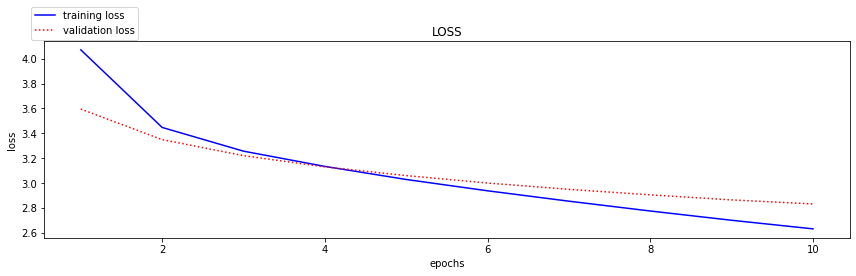

In [82]:
plot_history(history)


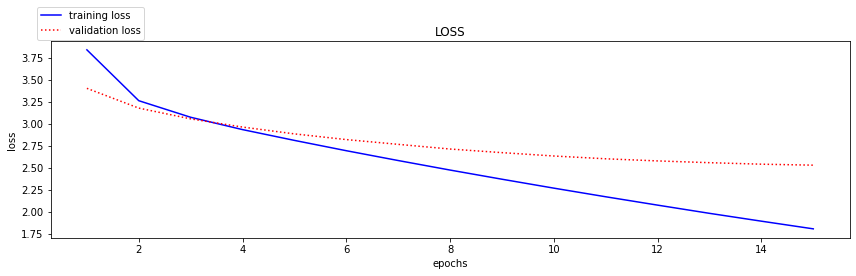

In [83]:
plot_history(ch_history)

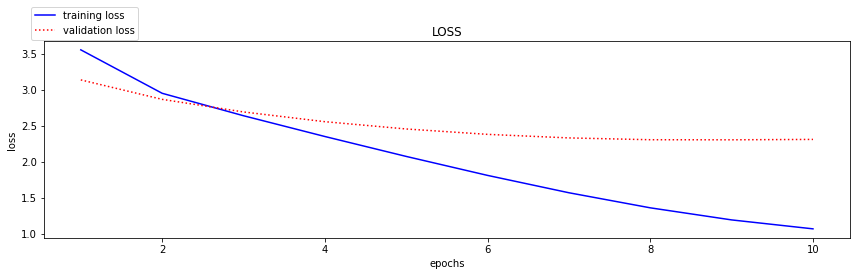

In [84]:
plot_history(ch_history2)

# 회고

- 목표인 2.2이하를 하기위해 hiddensize와 embedding size ephochs를 건들여봤다.
- history는 기존의 lms , ch_histroy는 embedding size와 hidden size를 2의승배로 곱해주고 ephocs를 15로 늘려봤는데 결국 validation은 더디게 떨어졌다.
- ch_history2는 한번다 ch_history와 embedding_size를 두배로 해보았고 2.3까지는 잘갔는데 그 뒤로는 더디게 떨어졌다.

## 어느 순간부터 더디게 떨어지는 validation을 보아 embedding size와 hidden size가 ephocs보다 더 중요 요인인것을 알게되었다.

##  hidden_size와 embedding_size에 대해 알아보고 data에 따라 사이즈를 어떻게 결정하는지 알고싶었다.